In [257]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.contrib.layers import fully_connected

In [258]:
%matplotlib notebook

In [718]:
data = pd.read_csv('./data/fcao_data.csv')

In [719]:
X_train1 = data.iloc[:,1].values.reshape(-1,1)
X_train2 = data.iloc[:,2].values.reshape(-1,1)
X_train3 = data.iloc[:,3].values.reshape(-1,1)
X_train4 = data.iloc[:,4].values.reshape(-1,1)
X_train5 = data.iloc[:,5].values.reshape(-1,1)

In [720]:
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()
scaler_4 = MinMaxScaler()
scaler_5 = MinMaxScaler()

In [721]:
X_train1 = scaler_1.fit_transform(X_train1).reshape(-1)
X_train2 = scaler_2.fit_transform(X_train2).reshape(-1)
X_train3 = scaler_3.fit_transform(X_train3).reshape(-1)
X_train4 = scaler_4.fit_transform(X_train4).reshape(-1)
X_train5 = scaler_5.fit_transform(X_train5).reshape(-1)

In [722]:
X_test1 = X_train1
X_test2 = X_train2
X_test3 = X_train3[5000000:10000000]
X_test4 = X_train4[5000000:10000000]
X_test5 = X_train5[5000000:10000000]

In [723]:
X_train1 = X_train1[400000:1000000]
X_train2 = X_train2[400000:1000000]
X_train3 = X_train3[400000:1000000]

<IPython.core.display.Javascript object>


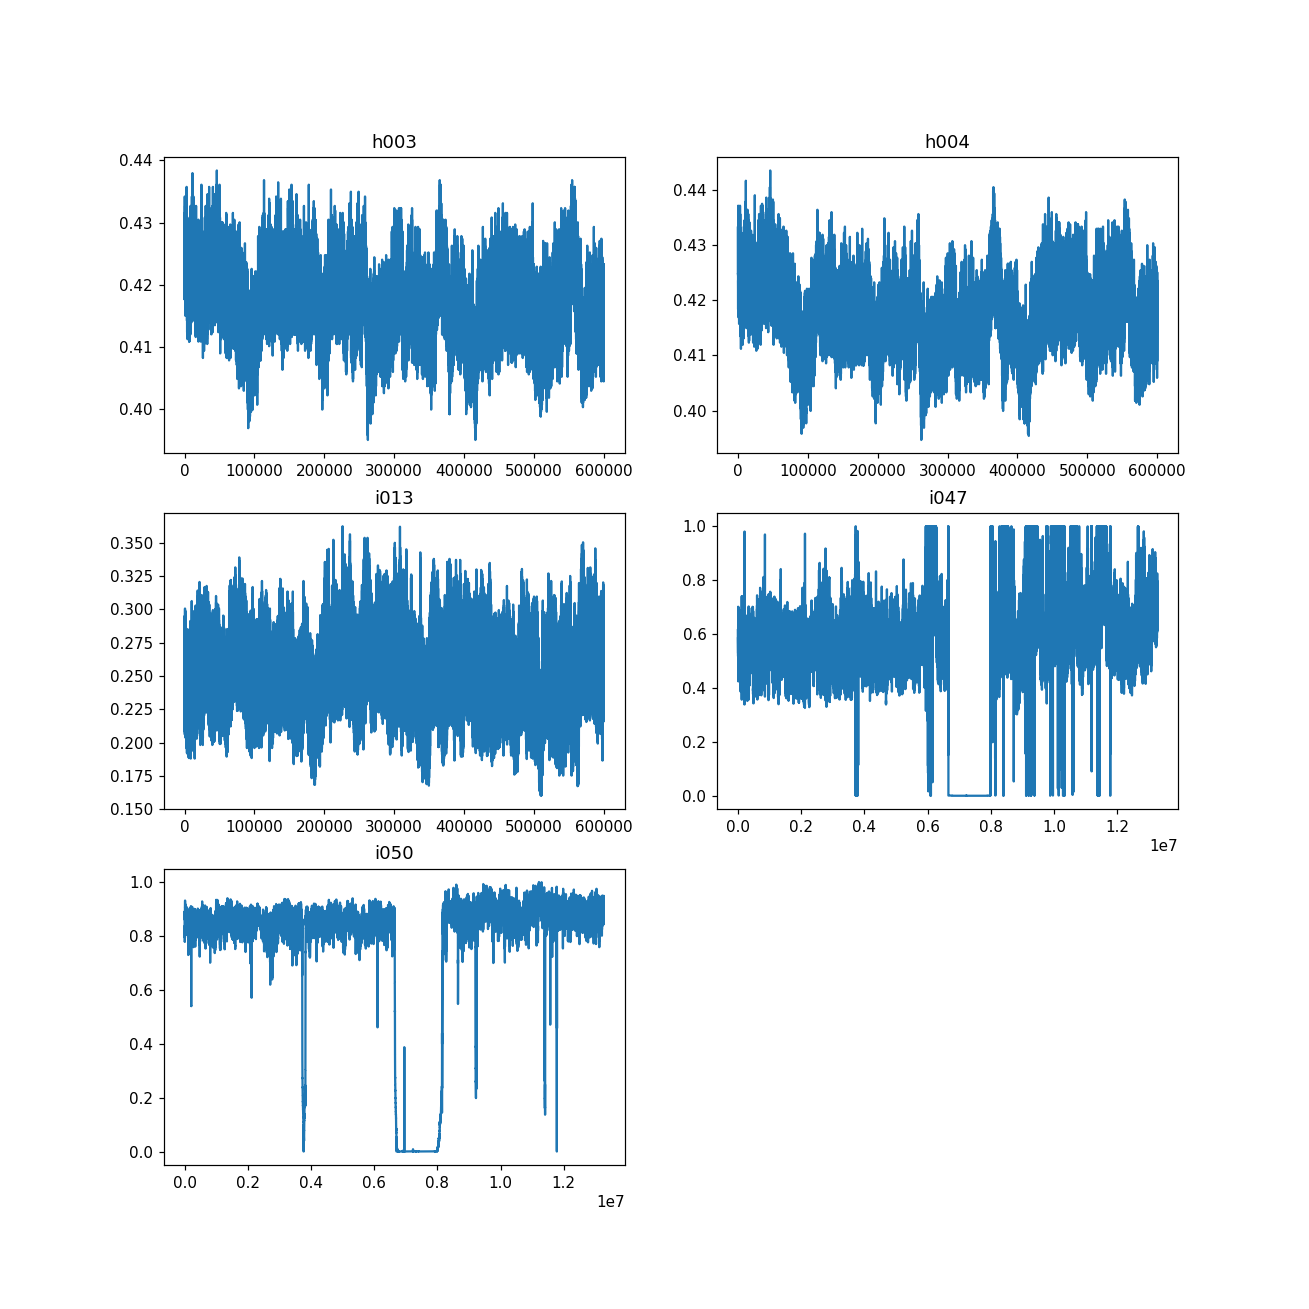

In [724]:
plt.figure(figsize=(12, 12))
plt.subplot(321)
plt.plot(range(len(X_train1)),X_train1)
plt.title('h003')
plt.subplot(322)
plt.plot(range(len(X_train2)),X_train2)
plt.title('h004')
plt.subplot(323)
plt.plot(range(len(X_train3)),X_train3)
plt.title('i013')
plt.subplot(324)
plt.plot(range(len(X_train4)),X_train4)
plt.title('i047')
plt.subplot(325)
plt.plot(range(len(X_train5)),X_train5)
plt.title('i050')
plt.show()

In [725]:
seq_len = 2096 

batch_size = 128

In [726]:
def generate_sequence(data,seq_len):
    
    num_sequence =  len(data) // seq_len
    
    all_sequence = []
    for i in range(num_sequence):
        all_sequence.append(data[i*seq_len:(i+1)*seq_len])
    return all_sequence 

In [727]:
def generate_batch(data , batch_size):
    
    num_batch =  len(data) // batch_size
    train_data = []
    for i in range(num_batch):
        train_data.append(data[i*batch_size:(i+1)*batch_size])
    return train_data

In [728]:
X_train_seq1 = generate_sequence(X_train1,seq_len)
X_test_seq1 = generate_sequence(X_test1,seq_len)
X_train_batch1 = generate_batch(X_train_seq1, batch_size)
X_test_batch1 = generate_batch(X_test_seq1, batch_size)

X_train_seq2 = generate_sequence(X_train2,seq_len)
X_test_seq2 = generate_sequence(X_test2,seq_len)
X_train_batch2 = generate_batch(X_train_seq2, batch_size)
X_test_batch2 = generate_batch(X_test_seq2, batch_size)


X_train_seq3 = generate_sequence(X_train3,seq_len)
X_test_seq3 = generate_sequence(X_test3,seq_len)
X_train_batch3 = generate_batch(X_train_seq3, batch_size)
X_test_batch3 = generate_batch(X_test_seq3, batch_size)

X_train_seq4 = generate_sequence(X_train4,seq_len)
X_test_seq4 = generate_sequence(X_test4,seq_len)
X_train_batch4 = generate_batch(X_train_seq4, batch_size)
X_test_batch4 = generate_batch(X_test_seq4, batch_size)

X_train_seq5 = generate_sequence(X_train5,seq_len)
X_test_seq5 = generate_sequence(X_test5,seq_len)
X_train_batch5 = generate_batch(X_train_seq5, batch_size)
X_test_batch5 = generate_batch(X_test_seq5, batch_size)

In [729]:
def deepautoencoder(layer , num_inputs,X,activation):
    hidden_layer = []
    hidden_layer.append(X)
    for i in range(0,len(layer)):
        hidden = fully_connected(hidden_layer[i], layer[i], activation_fn=activation)
        hidden_layer.append(hidden)
    output_layer = fully_connected(hidden_layer[i+1], num_inputs, activation_fn=None)
    middle_layer = hidden_layer[len(hidden_layer)//2]
    return output_layer , middle_layer

In [730]:
tf.reset_default_graph() 
def train_DAE(num_inputs,layer , num_epochs , learning_rate,X_train_batch ,X_test_batch ):
    
    actf = tf.nn.relu
    act_func = tf.nn.relu
    X = tf.placeholder(tf.float32, shape=[None, num_inputs])
    initializer = tf.variance_scaling_initializer()
    output_layer , middle_layer = deepautoencoder(layer ,num_inputs,X, act_func)
    loss = tf.reduce_mean(tf.square(output_layer - X))
    
    #tf.train.RMSPropOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
    
    # Training
    with tf.Session() as sess:
        sess.run(init)

        # Epoch == Entire Training Set
        for epoch in range(num_epochs):
            
            all_loss = []
            num_batches = len(X_train_batch)
            X_batch = X_train_batch[0]
            for iteration in range(1,num_batches):
                sess.run(train, feed_dict={X: X_batch})
                X_batch = X_train_batch[iteration]
                all_loss.append(loss.eval(feed_dict={X: X_batch}) )
                

            training_loss = np.array(all_loss).mean()

            print("Epoch {} Complete. Training Loss: {}".format(epoch,training_loss))


        train_lost = []
        train_middle = []
        X_batch_train =  X_train_batch[0]
        for i in range(1,len(X_train_batch)):
            train_lost.append(loss.eval(feed_dict = {X:X_batch_train}))
            train_middle.append(middle_layer.eval(feed_dict = {X:X_batch_train} ))
            X_batch_train =  X_train_batch[i]


        test_lost = []
        test_middle = []
        X_batch_test =  X_test_batch[0]
        for i in range(1,len(X_test_batch)):
            test_lost.append(loss.eval(feed_dict = {X:X_batch_test}))
            test_middle.append(middle_layer.eval(feed_dict = {X:X_batch_test} ))
            X_batch_test =  X_test_batch[i]
            
        return train_middle , test_middle

In [773]:
train_middle , test_middle = train_DAE(seq_len,[256,128,96,48,32,16,32,48,96,128,256] , 150 , 0.01,X_train_batch3,X_test_batch3)

Epoch 0 Complete. Training Loss: 0.016812385991215706
Epoch 1 Complete. Training Loss: 28.05404281616211
Epoch 2 Complete. Training Loss: 0.0115130003541708
Epoch 3 Complete. Training Loss: 0.05756932869553566
Epoch 4 Complete. Training Loss: 0.062015876173973083
Epoch 5 Complete. Training Loss: 0.06253932416439056
Epoch 6 Complete. Training Loss: 0.06077946349978447
Epoch 7 Complete. Training Loss: 0.050990886986255646
Epoch 8 Complete. Training Loss: 0.026301372796297073
Epoch 9 Complete. Training Loss: 0.015245799906551838
Epoch 10 Complete. Training Loss: 0.0013199944514781237
Epoch 11 Complete. Training Loss: 0.003335037734359503
Epoch 12 Complete. Training Loss: 0.001623509218916297
Epoch 13 Complete. Training Loss: 0.005437736865133047
Epoch 14 Complete. Training Loss: 0.002026274800300598
Epoch 15 Complete. Training Loss: 0.003355648135766387
Epoch 16 Complete. Training Loss: 0.002425180748105049
Epoch 17 Complete. Training Loss: 0.0011630920926108956
Epoch 18 Complete. Trainin

Epoch 149 Complete. Training Loss: 0.000661406375002116


In [774]:
train_middle = np.array(train_middle).reshape(len(train_middle)*len(train_middle[0]), 16);
test_middle = np.array(test_middle).reshape(len(test_middle)*len(test_middle[0]), 16);

In [775]:
def distance(data):
    result = []
    for i in range(len(data) - 1):
        result.append(np.linalg.norm(data[i]-data[i+1]))
    return result

In [776]:
dist_train  = distance(train_middle)
dist_test  = distance(test_middle)

In [777]:
a = []
for i in range(len(dist_test)-1):
    a.append(abs(dist_test[i]-dist_test[i+1]))

<IPython.core.display.Javascript object>


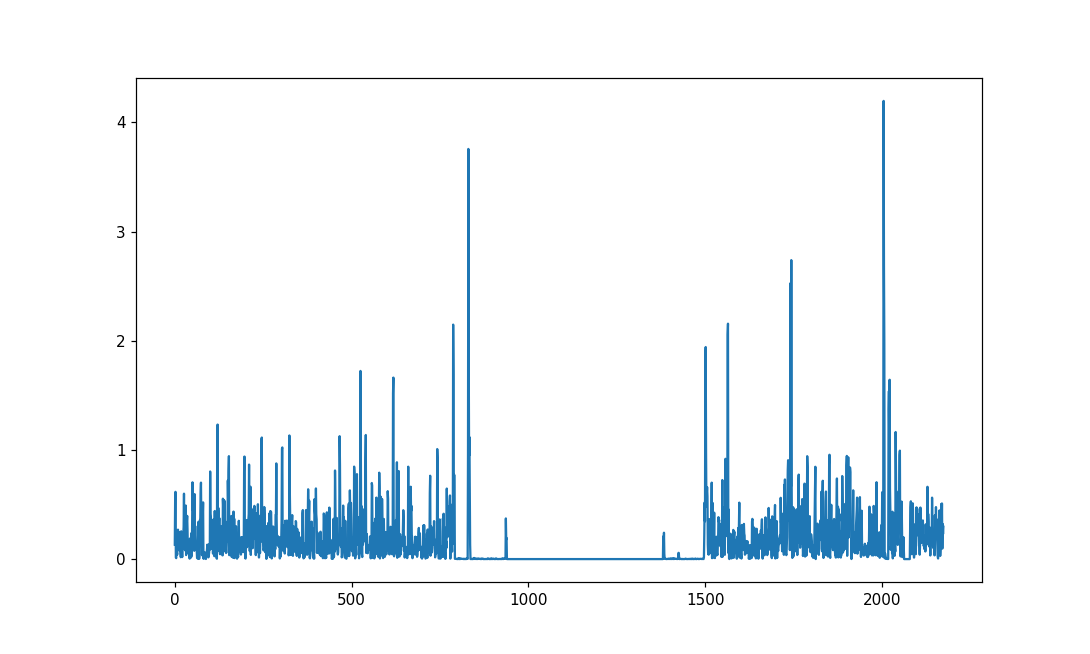

In [778]:
plt.figure(figsize=(10, 6))
plt.plot(a)
plt.show()

<IPython.core.display.Javascript object>


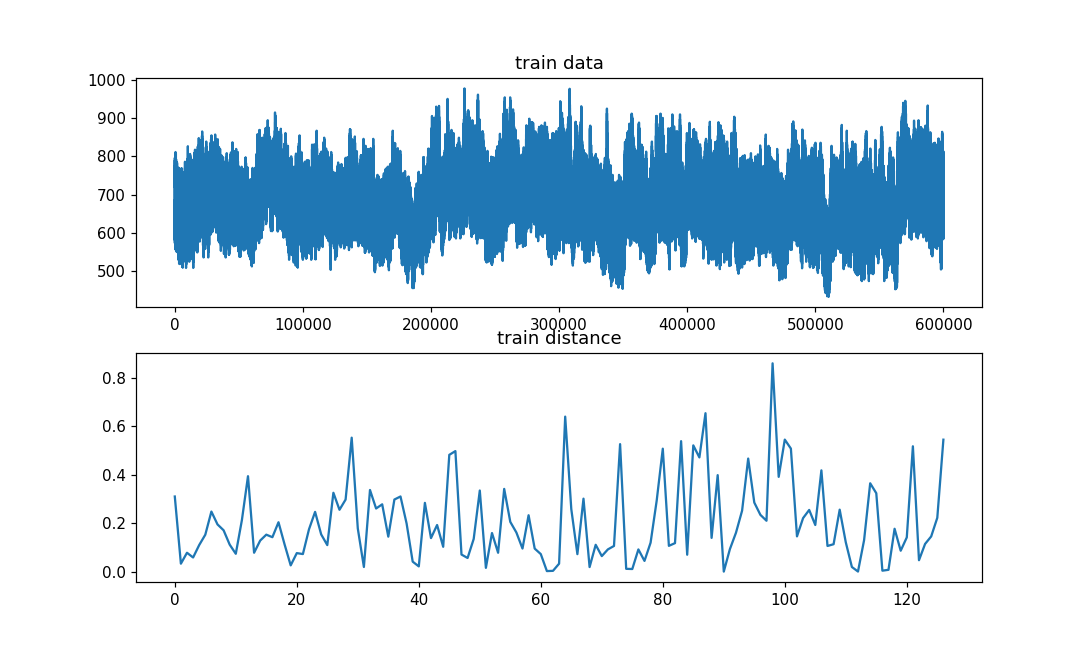

In [779]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
X_train3_inv = scaler_3.inverse_transform(X_train3.reshape(-1,1))
plt.plot(range(len(X_train3_inv)),X_train3_inv)
plt.title('train data')

plt.subplot(212)
plt.plot(dist_train)
plt.title('train distance')
plt.show()

<IPython.core.display.Javascript object>


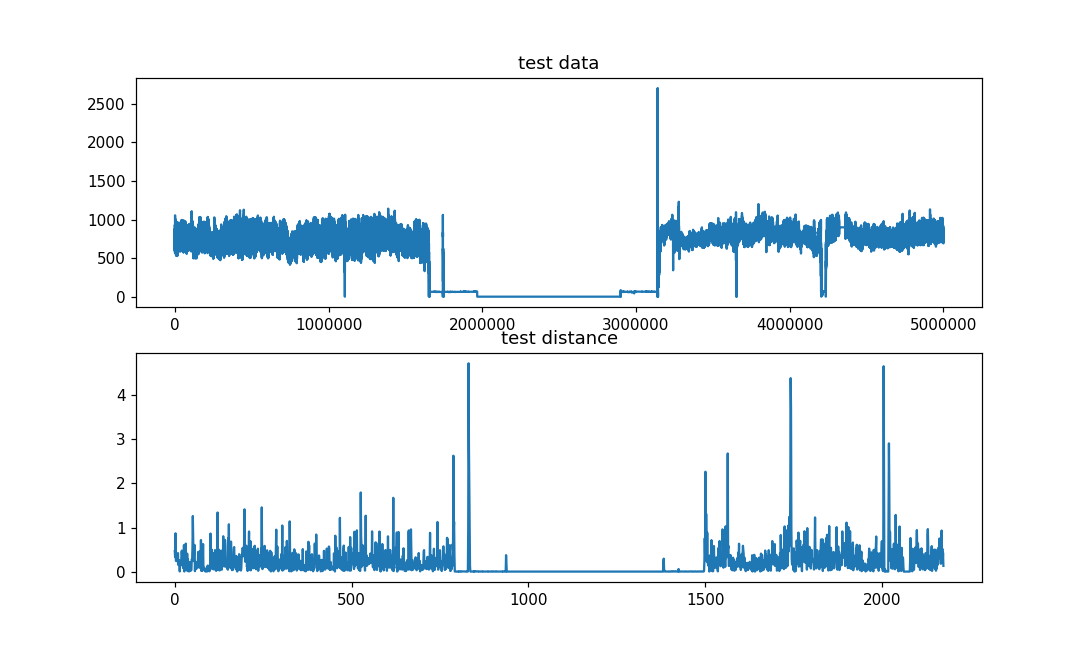

In [780]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
X_test3_inv = scaler_3.inverse_transform(X_test3.reshape(-1,1))
plt.plot(range(len(X_test3_inv)),X_test3_inv)
plt.title('test data')
plt.subplot(212)
plt.plot(dist_test)
plt.title('test distance')
plt.show()

In [781]:
def detect_anamolies(distance,seq_len,min_thre , max_thre):
    anomalies = []
    for i in range (len(distance)):
        if (distance[i]> min_thre and distance[i] < max_thre)or(distance[i] ==0.000) :
            anomalies.append(range((i)*seq_len,(i+2)*seq_len))
    return anomalies

In [782]:
import matplotlib.pyplot as plt
import numpy as np

data =  pd.read_csv('./data/123.csv').iloc[:,:].values

def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(10, 3))
    start= 0
    for seg in segments:
        end = start + len(seg)
        if start == 0 :
            l, = plt.gca().plot(x[start:end],y[start:end],lw=2,c=seg[0])
        else:
            l, = plt.gca().plot(x[start-1:end],y[start-1:end],lw=2,c=seg[0])
        start = end
    return segments

In [783]:
def plot_anomalies(anomalies, data):
    
    colors = []
    for i in range(len(data)):
        colors.append('blue')
        
    for i in range(len(anomalies)):
        one_anomalies = anomalies[i]
        for j in range(len(one_anomalies)):
            colors[one_anomalies[j]] = 'red'
    x = range(len(data))
    y = data 

    segments = plot_multicolored_lines(x,y,colors)
    plt.show()
    return 

In [784]:
max(dist_train)

0.85987765

In [787]:
#anomalies = detect_anamolies(dist_test,seq_len,0.15,7) // for X_train1
anomalies = detect_anamolies(dist_test,seq_len,0.5,5)

<IPython.core.display.Javascript object>


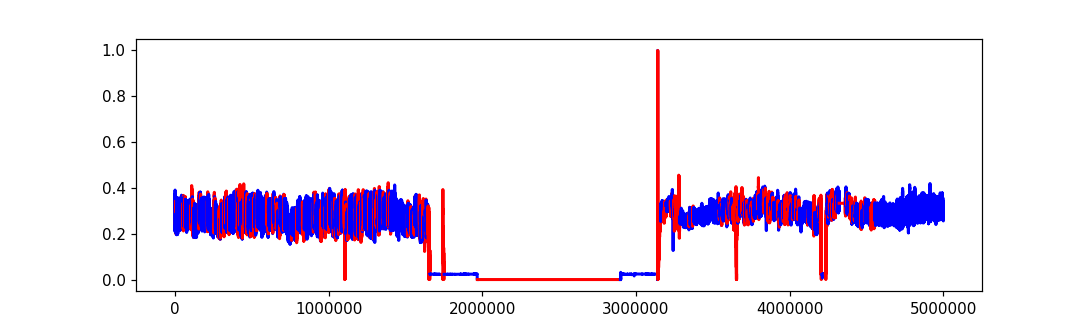

In [788]:
plot_anomalies(anomalies,  X_test3)

In [309]:
def split_data(original_data ,distance,seq_len,min_thre , max_thre):
    breakpoint = []
    for i in range (len(distance)):
        if distance[i]> min_thre and distance[i] < max_thre:
            breakpoint.append(i*seq_len)
    return breakpoint

def plot_breakpoint(break_point,data):
    plt.figure(figsize=(10, 3))
    plt.plot(range(len(data)),data)
    for xc in break_point:
        plt.axvline(x=xc, color='r', linestyle='--')
    plt.show

In [ ]:
breakpoint = split_data(X_train_batch1,dist, seq_len,0.5,15)
plot_breakpoint(breakpoint, X_train1)

In [ ]:
breakpoint = split_data(X_train_batch1,dist, seq_len,0.1,0.2)
plot_breakpoint(breakpoint, X_train1)

In [317]:
a = range(2,10)

In [323]:
len(a)

8